# Loading Images #

In [1]:
import os
import glob

"""
the function below just loads picks up the right paths from the test or the validation directory and
arranges them in a dictionary
The directory structure is that say we pickup a random directory X... under it we will have one or multiple clean images 
and under sub-dir named distortion under which all the distorted images are present
"""

def collect_image_paths(root_dir):
    person_dict = {}

    for person_folder in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, person_folder)
        if not os.path.isdir(folder_path):
            continue

        # Undistorted images (exclude anything in subfolders)
        all_jpgs = glob.glob(os.path.join(folder_path, "*.jpg"))
        clean_imgs = [f for f in all_jpgs if "distortion" not in f]

        # Distorted images
        distortion_dir = os.path.join(folder_path, "distortion")
        distortion_imgs = []
        if os.path.exists(distortion_dir):
            distortion_imgs = glob.glob(os.path.join(distortion_dir, "*.jpg"))

        if clean_imgs:
            person_dict[person_folder] = {
                "clean": clean_imgs,  # store list, not just one
                "distorted": distortion_imgs
            }

    return person_dict

In [2]:
IMG_SIZE = 224

**Load Image Paths**

In [3]:
testing_dir = f"/kaggle/input/facecom/Comys_Hackathon5/Task_B/val"
testing_dict = collect_image_paths(testing_dir)

# Generating Pairs of Images from val directory for comparing similarity 

In [4]:
import random

def prepare_gallery_and_probe(person_dict, seed=42):
    """
    From the person_dict:
    - Pick 1 random clean image per identity for the gallery
    - All remaining images (clean or distorted) are probes
    """
    random.seed(seed)
    gallery = {}  # label: image_path
    probe_set = []  # (image_path, true_label)

    label_map = {}  # person_folder → label (0 to 249)
    for idx, (person_id, images) in enumerate(person_dict.items()):
        # Assign unique label to this identity
        label_map[person_id] = idx

        clean_imgs = images["clean"]
        distorted_imgs = images["distorted"]

        # Randomly pick one clean image for gallery
        gallery_img = random.choice(clean_imgs)
        gallery[idx] = gallery_img  # label: path

        # Add remaining clean images (excluding gallery_img) to probe
        for img in clean_imgs:
            if img != gallery_img:
                probe_set.append((img, idx))

        # Add all distorted images to probe
        for img in distorted_imgs:
            probe_set.append((img, idx))

    return gallery, probe_set, label_map

In [5]:
gallery, probe_set, label_map = prepare_gallery_and_probe(testing_dict)

In [6]:
print(f"Total identities (gallery): {len(gallery)}")
print(f"Total probe images: {len(probe_set)}")
print(f"Sample probe image: {probe_set[0]}")

Total identities (gallery): 250
Total probe images: 3126
Sample probe image: ('/kaggle/input/facecom/Comys_Hackathon5/Task_B/val/009_frontal/distortion/009_frontal_foggy.jpg', 0)


In [7]:
from PIL import Image
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

def load_image(path):
    img = Image.open(path).convert("RGB")
    return transform(img)

In [8]:
# === Config ===
USE_DCT_ATTENTION = False   # 🔄 flip to True later if you want attention
IMG_SIZE = 224

In [9]:
import tqdm.notebook as tqdm

# Loading the Model

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

# global toggle (make sure this exists in a config cell)
# USE_DCT_ATTENTION = False

class SiameseNet(nn.Module):          # renamed (name is up to you)
    def __init__(self, backbone="resnet18", pretrained=True):
        super().__init__()

        # backbone (easily switchable)
        base = getattr(models, backbone)(pretrained=pretrained)
        self.feature_extractor = nn.Sequential(*list(base.children())[:-1])  # -> [B, 512, 1, 1]

        # head
        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )
    
    def extract_embedding(self, img):
        with torch.no_grad():
            f = self.feature_extractor(img).view(img.size(0), -1)  # [B, 512]
        return f


    def forward(self, img1, img2, attn_map=None):
        """
        img1, img2: [B, 3, H, W]
        attn_map   : [B, 1, H, W] or None
        """
        if USE_DCT_ATTENTION and attn_map is not None:
            attn_map = attn_map.expand(-1, 3, -1, -1)  # broadcast to RGB
            img1, img2 = img1 * attn_map, img2 * attn_map

        f1 = self.feature_extractor(img1).view(img1.size(0), -1)  # [B, 512]
        f2 = self.feature_extractor(img2).view(img2.size(0), -1)  # [B, 512]

        out = self.fc(torch.cat([f1, f2], dim=1))  # [B, 1]  (logits)
        return out

In [11]:
def build_gallery_embeddings(model, gallery, device='cuda'):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for label, path in gallery.items():
            img = load_image(path).unsqueeze(0).to(device)
            emb = model.extract_embedding(img)  # [1, 512]
            embeddings.append(emb)
            labels.append(label)

    gallery_tensor = torch.cat(embeddings, dim=0)  # [G, 512]
    label_tensor = torch.tensor(labels)
    return gallery_tensor, label_tensor

In [12]:
model = SiameseNet(backbone="resnet18", pretrained=False)  # pretrained=False during load
model.load_state_dict(torch.load("/kaggle/input/facecom_siam_model/pytorch/default/1/siamese_best_epoch2_acc0.8858.pt", map_location='cuda'))  # or 'cuda'
model.to('cuda')
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SiameseNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

# Testing Script 

In [13]:
gallery_embs, gallery_labels = build_gallery_embeddings(model, gallery, device='cuda')

# Normalize for cosine similarity (optional but recommended)
gallery_embs = torch.nn.functional.normalize(gallery_embs, p=2, dim=1)
gallery_labels = gallery_labels.to('cuda')

**Evaluation based on class prediction by cosine similarity**

In [14]:
from torch.utils.data import DataLoader, Dataset

class ProbeDataset(Dataset):
    def __init__(self, probe_set):
        self.data = probe_set

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        img = load_image(path)
        return img, label

def evaluate_batch(model, gallery_embs, gallery_labels, probe_set, batch_size=32, device='cuda'):
    model.eval()
    probe_loader = DataLoader(ProbeDataset(probe_set), batch_size=batch_size, shuffle=False)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for imgs, labels in tqdm.tqdm(probe_loader, desc="Evaluating"):
            imgs = imgs.to(device)  # [B, 3, H, W]
            labels = labels.tolist()

            probe_embs = model.extract_embedding(imgs)  # [B, 512]

            # Cosine similarity: higher is more similar
            sims = torch.matmul(probe_embs, gallery_embs.T)  # [B, G]
            preds = torch.argmax(sims, dim=1)  # [B]
            pred_labels = gallery_labels[preds].tolist()

            y_true.extend(labels)
            y_pred.extend(pred_labels)

    return y_true, y_pred

In [15]:
y_true, y_pred = evaluate_batch(model, gallery_embs, gallery_labels, probe_set, batch_size=32, device='cuda')

Evaluating:   0%|          | 0/98 [00:00<?, ?it/s]

**Some sample predictions**

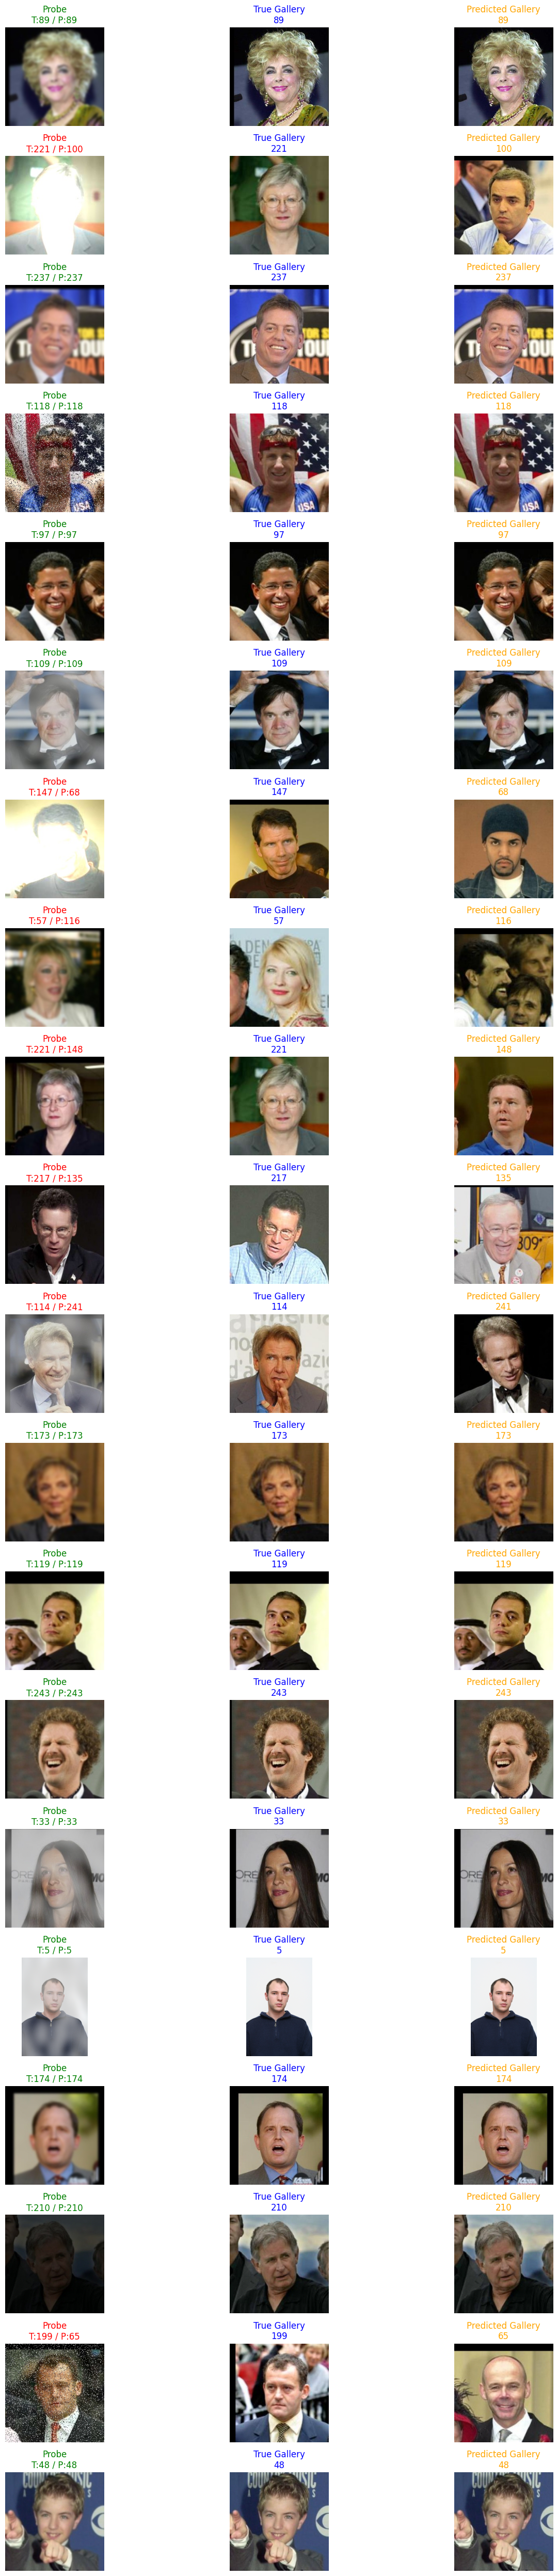

In [16]:
import matplotlib.pyplot as plt
import random

def show_random_predictions(probe_set, y_true, y_pred,gallery, num_samples=20):
    indices = random.sample(range(len(probe_set)), num_samples)

    plt.figure(figsize=(15, num_samples * 2.5))  # Wider for 3 columns
    for i, idx in enumerate(indices):
        img_path, true_label = probe_set[idx]
        pred_label = y_pred[idx]
        
        # Load images
        img_probe = Image.open(img_path).convert("RGB")
        img_gallery_true = Image.open(gallery[true_label]).convert("RGB")
        img_gallery_pred = Image.open(gallery[pred_label]).convert("RGB")
        
        # Column 1: Probe image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(img_probe)
        plt.axis('off')
        plt.title(f"Probe\nT:{true_label} / P:{pred_label}", color='green' if true_label == pred_label else 'red')
        
        # Column 2: True gallery
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(img_gallery_true)
        plt.axis('off')
        plt.title(f"True Gallery\n{true_label}", color='blue')
        
        # Column 3: Predicted gallery
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(img_gallery_pred)
        plt.axis('off')
        plt.title(f"Predicted Gallery\n{pred_label}", color='orange')


    plt.tight_layout()
    plt.show()

# 🔍 Run it
show_random_predictions(probe_set, y_true, y_pred, gallery, num_samples=20)

# Evaluation Results

In [17]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

In [18]:
acc, f1 = compute_metrics(y_true, y_pred)
print(f"Top-1 Accuracy: {acc:.4f}")
print(f"Macro F1 Score: {f1:.4f}")

Top-1 Accuracy: 0.5272
Macro F1 Score: 0.6396


Embed:   0%|          | 0/49 [00:00<?, ?it/s]

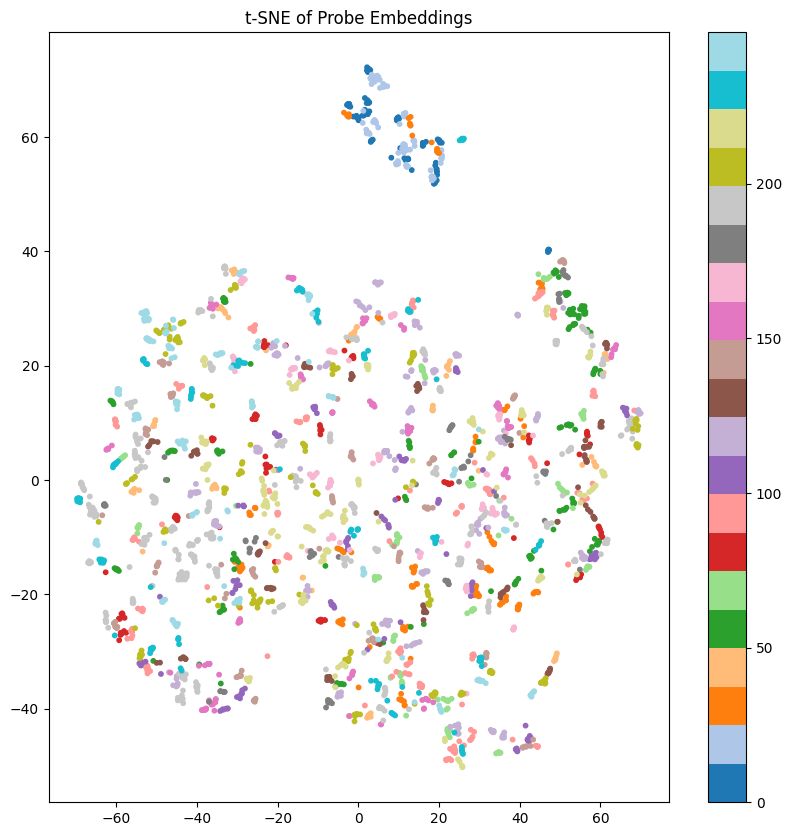

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get all probe embeddings
probe_loader = DataLoader(ProbeDataset(probe_set), batch_size=64, shuffle=False)
all_embs, all_labels = [], []

model.eval()
with torch.no_grad():
    for imgs, labels in tqdm.tqdm(probe_loader, desc="Embed"):
        imgs = imgs.cuda()
        embs = model.extract_embedding(imgs)
        all_embs.append(embs.cpu())
        all_labels.extend(labels)

all_embs = torch.cat(all_embs, dim=0).numpy()

# Reduce dimensions
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_embs = tsne.fit_transform(all_embs)

# Plot
plt.figure(figsize=(10, 10))
scatter = plt.scatter(reduced_embs[:, 0], reduced_embs[:, 1], c=all_labels, cmap='tab20', s=10)
plt.title("t-SNE of Probe Embeddings")
plt.colorbar(scatter)
plt.show()

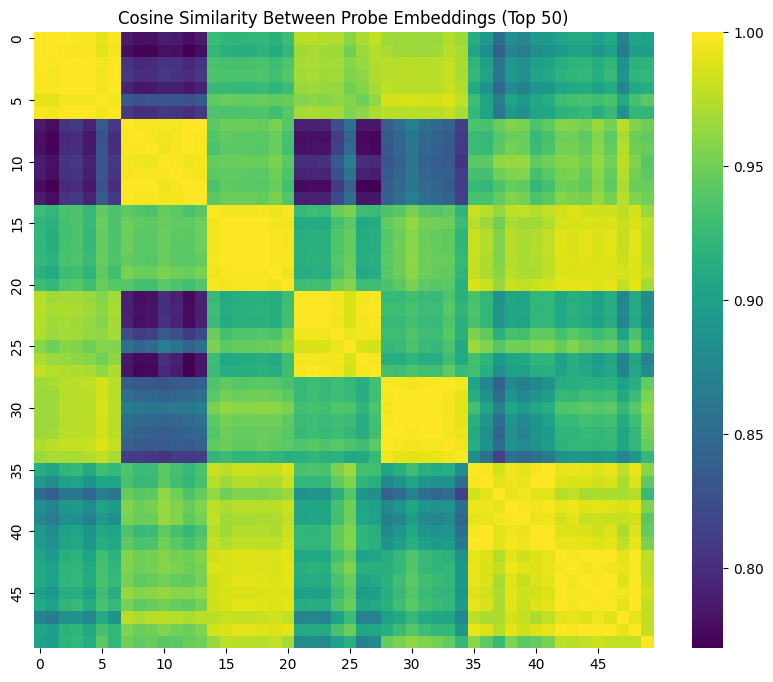

In [20]:
import seaborn as sns
import numpy as np

# Compute cosine similarity between first 50 embeddings
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(all_embs[:50])

plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, xticklabels=5, yticklabels=5, cmap="viridis")
plt.title("Cosine Similarity Between Probe Embeddings (Top 50)")
plt.show()

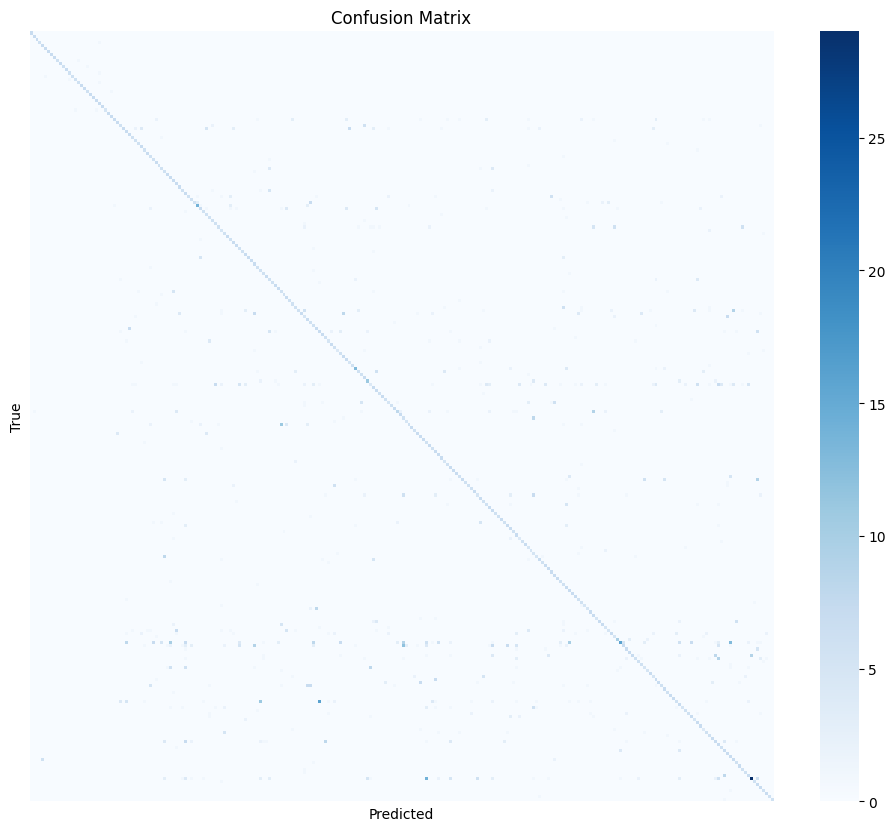

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [22]:
def generate_balanced_pairs(person_dict, max_pos_per_person=None, neg_per_pos=1):
    pairs, labels = [], []
    people = list(person_dict.keys())

    for person in people:
        imgs = person_dict[person]["clean"] + person_dict[person]["distorted"]
        pos_pairs = []

        # Positive pairs
        for i in range(len(imgs)):
            for j in range(i + 1, len(imgs)):
                pos_pairs.append((imgs[i], imgs[j]))

        if max_pos_per_person:
            pos_pairs = random.sample(pos_pairs, min(len(pos_pairs), max_pos_per_person))

        for pair in pos_pairs:
            pairs.append(pair)
            labels.append(1)

            # Add negatives
            neg_persons = [p for p in people if p != person]
            for _ in range(neg_per_pos):
                neg_p = random.choice(neg_persons)
                neg_imgs = person_dict[neg_p]["clean"] + person_dict[neg_p]["distorted"]
                if not neg_imgs:
                    continue
                neg_pair = (pair[0], random.choice(neg_imgs))
                pairs.append(neg_pair)
                labels.append(0)

    return pairs, labels

In [23]:
pairs, pair_labels = generate_balanced_pairs(
    testing_dict,
    max_pos_per_person=None,   # or None to use all positives
    neg_per_pos=1            # e.g. 1 negative per positive
)

from collections import Counter
print(Counter(pair_labels))

Counter({1: 51432, 0: 51432})


In [24]:
from itertools import combinations, product

def generate_all_pairs(person_dict):
    pairs = []
    labels = []

    people = list(person_dict.keys())

    # Positive pairs
    for person in people:
        imgs = person_dict[person]["clean"] + person_dict[person]["distorted"]
        for i, j in combinations(imgs, 2):
            pairs.append((i, j))
            labels.append(1)

    # Negative pairs
    for i in range(len(people)):
        for j in range(i + 1, len(people)):
            imgs1 = person_dict[people[i]]["clean"] + person_dict[people[i]]["distorted"]
            imgs2 = person_dict[people[j]]["clean"] + person_dict[people[j]]["distorted"]
            for img1, img2 in product(imgs1, imgs2):
                pairs.append((img1, img2))
                labels.append(0)

    return pairs, labels

In [25]:
class SiamesePairDataset(Dataset):
    def __init__(self, pairs, labels, transform):
        self.pairs = pairs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1 = self.transform(Image.open(self.pairs[idx][0]).convert("RGB"))
        img2 = self.transform(Image.open(self.pairs[idx][1]).convert("RGB"))
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img1, img2, label

**Evaluation based on image-pair similarity**

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_siamese_binary(model, dataloader, device='cuda'):
    model.eval()
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for img1, img2, label in tqdm.tqdm(dataloader, desc="Evaluating pairs"):
            img1, img2 = img1.to(device), img2.to(device)
            label = label.to(device)
            

            output = model(img1, img2)  # logits
            prob = torch.sigmoid(output.view(-1))

            pred = (prob > 0.5).float()

            all_labels.extend(label.cpu().numpy())
            all_preds.extend(pred.cpu().numpy())
            all_scores.extend(prob.cpu().numpy())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    try:
        auc = roc_auc_score(all_labels, all_scores)
    except:
        auc = float('nan')

    cm = confusion_matrix(all_labels, all_preds)

    return acc, prec, rec, f1, auc, cm, all_labels, all_preds, all_scores

In [27]:
pair_dataset = SiamesePairDataset(pairs, pair_labels, transform=transform)
pair_loader = DataLoader(pair_dataset, batch_size=64, shuffle=False, num_workers=4)

acc, prec, rec, f1, auc, cm, all_labels, all_preds, all_scores = evaluate_siamese_binary(model, pair_loader)

print(f"Top-1 Accuracy: {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC AUC       : {auc:.4f}")

Evaluating pairs:   0%|          | 0/1608 [00:00<?, ?it/s]

Top-1 Accuracy: 0.7251
Precision     : 0.8035
Recall        : 0.5960
F1 Score      : 0.6844
ROC AUC       : 0.8423


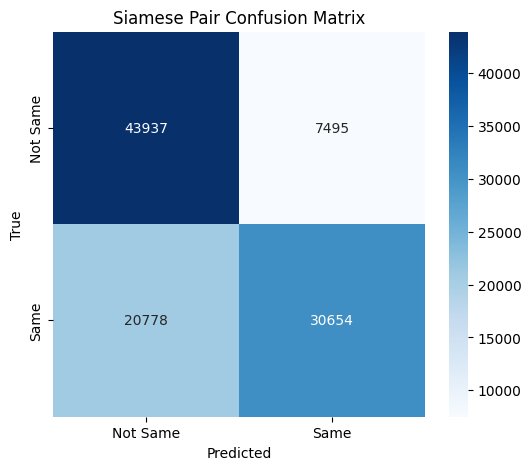

In [28]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Same", "Same"], yticklabels=["Not Same", "Same"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Siamese Pair Confusion Matrix")
plt.show()